## Relative humidity issue

In RCE runs with no stratospheric relaxation of temperature $T$ or water vapour mixing ratio $q$, why does relative humidity (RH) go to > 100% above about 150 hPa?

### Conclusions

- If ideal radation is used then stratospheric relaxation of T and q to reference RCE profiles is required to stop the temperature from drifting too much in the stratosphere. In RCE runs with no relaxation of T and q the T profile became far too cold. Real stratosphere should get down to abou 190 K in the tropics, we were seeing < 170 K. 

- The various formulations for saturation vapour pressure (SVP) differ at low temperatures. The most reliable one I have found is that of Murphy 2005 which can handle temperatures from 123 K to 332 K. 

- The WRF microphysics schemes of Morrison and Thompson both use Flatau 1992 for saturation vapour pressure, but constain temperatures below -80C to the value for -80C. This means that although supersaturation should have occured in the stratosphere at the very cold temperatures, it did not and no condensate was formed by the microphysics schemes, which explains why the moisture was not removed from the stratosphere.

In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np

import modules.atmosphere as atm

# Figure settings.
plt.rcParams['figure.figsize'] = [15,5]          # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 14                   # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False # Don't use offsets in plots.

### Relative humidity calculation

Potential temperature vs. temperature relationship is

$$\theta = T \left( \frac{P_0}{P} \right)^{R/C_p},$$

where $R$ is the gas constant for dry air (287 J kg$^{-1}$ K$^{-1}$), $C_p$ is the specific heat of dry air at constant pressure ($7\times R/2$ J kg$^{-1}$ K$^{-1}$), and $P_0$ is a reference pressure ($1000$ hPa). So we have

$$T = \frac{\theta}{\left( \frac{P_0}{P} \right)^{R/C_p}}.$$

The saturation vapour pressure of water $e_s$ (hPa) is calculated either:

 - [Bolton 1980](https://journals.ametsoc.org/mwr/article/108/7/1046/62205) (range -30 to 35 C),
 - [Murphy 2005](https://doi.org/10.1256/qj.04.94) (range 123 K to 332 K),
 - Wexler 1976/1977, as quoted in [Flatau 1992](https://journals.ametsoc.org/jamc/article/31/12/1507/14870) (range > 0 C).
 - [Flatau 1992](https://journals.ametsoc.org/jamc/article/31/12/1507/14870) (range 188.15 to 343.15 K for water and 183.15 to 273.15 K for ice).

From the saturation vapour pressure the saturation specific humidity (kg kg$^{-1}$) can be calculated, using

$$
q_s = \frac{0.622 e_s}{p - 0.378 e_s},
$$

where $p$ is pressure in hPa. See Wallace and Hobbs 2006; this equation comes about because at saturation specific humidity $q_s$ is related to mixing ratio $w_s$ as

$$
q_s = \frac{w_s}{1+w_s}
$$

and

$$
w_s = 0.622 \frac{e_s}{p - e_s}.
$$

Then relative humidity is $(w/w_s) \times 100$ where $w$ is the water vapour mixing ratio in kg kg$^{-1}$. In WRF python, values $\gt 100$ are set to 100 and values less than 0 are set to 0. The WRF microphysics schemes of Morrison and Thompson both use Flatau 1992 method for saturation vapour pressure but if $T < -80$C the result for -80C is returned.

### Comparison of saturation vapour pressure methods

saturation_vapour_pressure_bolton: warning T outside valid range.
saturation_vapour_pressure_flatau: warning T outside valid range.
saturation_vapour_pressure_flatau: warning T outside valid range.


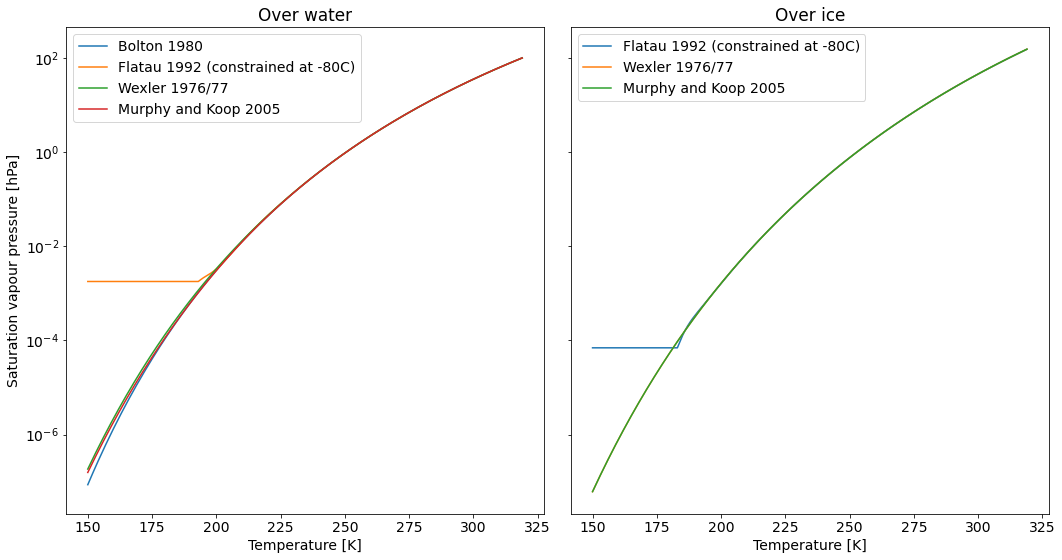

In [2]:
methods = {'bolton': 'Bolton 1980',
           'flatau': 'Flatau 1992 (constrained at -80C)',
           'wexler': 'Wexler 1976/77',
           'murphy': 'Murphy and Koop 2005'}

temp = np.arange(150,320,step=1)
fig, ax = plt.subplots(ncols=2, figsize=[15,8], sharey=True)

for method, name in methods.items():
    ax[0].plot(temp, atm.saturation_vapour_pressure(temp, method=method, over='water'), label=name)
    if method != 'bolton':
        ax[1].plot(temp, atm.saturation_vapour_pressure(temp, method=method, over='ice'), label=name)
    
ax[0].set_title('Over water')
ax[0].set_ylabel('Saturation vapour pressure [hPa]')
ax[0].set_xlabel('Temperature [K]')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].set_title('Over ice')
ax[1].set_xlabel('Temperature [K]')
ax[1].set_yscale('log')
ax[1].legend()

plt.tight_layout()
plt.show()

### Example of problem profiles at RCE

In this example the problematic profiles at RCE are shown, first using the Murphy 2005 method for calculating saturation vapour pressure, in which supersaturation is shown:

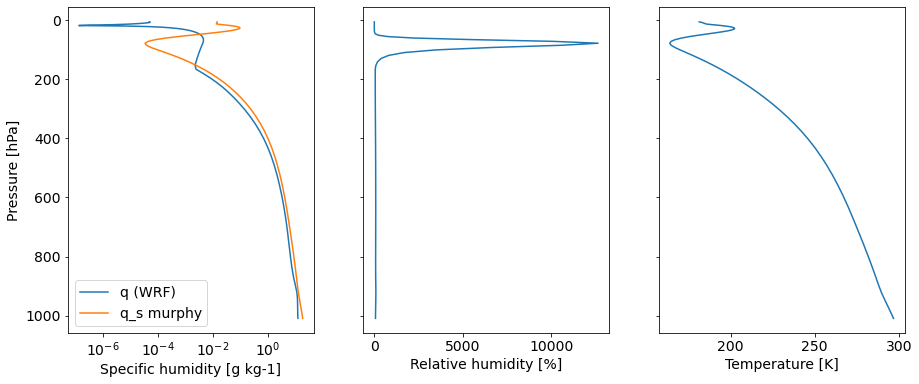

In [3]:
def plot_profile(method='murphy'):
    # Open file and calculate mean profiles.
    directory = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/RCE/'
    dat = xarray.open_dataset(directory+'wrfout_d01_2000-06-01_00:00:00')
    dat = dat[['T', 'P', 'PB', 'QVAPOR', 'RTHRATEN']].mean(['south_north', 'west_east', 'Time'], keep_attrs=True)

    # Calculate full potential temperature.
    dat['theta'] = dat.T + 300
    dat.theta.attrs = {'long_name': 'Potential temperature', 'units': 'K'}

    # Calculate full pressure.
    dat['pres'] = (dat.P + dat.PB) / 100
    dat.pres.attrs = {'long_name': 'Pressure', 'units': 'hPa'}

    # Calculate temperature, satuation vapour pressure, saturation mixing ratio, and relative humidity.
    dat['temp'] = atm.temp_from_theta(theta=dat.theta, p=dat.pres)
    dat['es'] = atm.saturation_vapour_pressure(T=dat.temp, over='water', method=method)
    dat['ws'] = atm.saturation_mixing_ratio(es=dat.es, p=dat.pres)
    dat['rh'] = atm.relative_humidity(theta=dat.theta, p=dat.pres, w=dat.QVAPOR, es_method=method)

    fig, ax = plt.subplots(figsize=[15,6], ncols=3, sharey=True)
    ax[0].plot(dat.QVAPOR*1000, dat.pres, label='q (WRF)')
    ax[0].plot(dat.ws*1000, dat.pres, label='q_s ' + method)
    ax[0].invert_yaxis()
    ax[0].set_xlabel('Specific humidity [g kg-1]')
    ax[0].set_ylabel('Pressure [hPa]')
    ax[0].set_xscale('log')
    ax[0].legend()

    ax[1].plot(dat.rh, dat.pres)
    ax[1].set_xlabel('Relative humidity [%]')

    ax[2].plot(dat.temp, dat.pres)
    ax[2].set_xlabel('Temperature [K]')
    plt.show()
    
plot_profile('murphy')

Second we show the same plots using the Flatau 1992 technique, constrained at -80C, that is used in the WRF microphysics schemes. These plots show no supersaturation is found, which explains why the microphysics schemes do not form condensate and remove water from the stratosphere in this case.

saturation_vapour_pressure_flatau: warning T outside valid range.
saturation_vapour_pressure_flatau: warning T outside valid range.


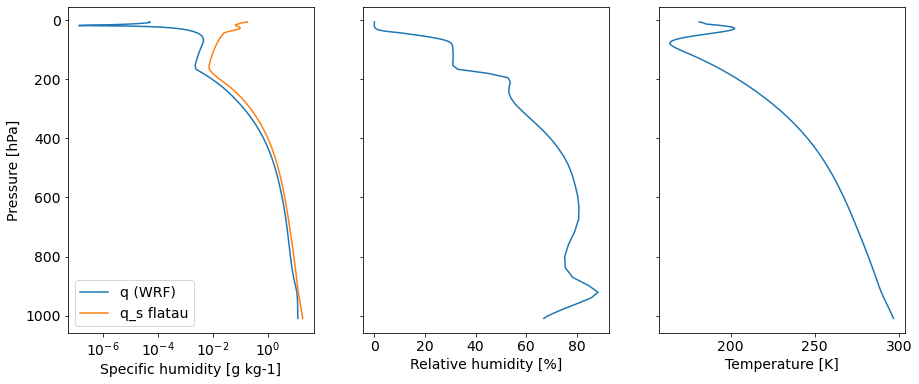

In [4]:
plot_profile('flatau')